# BICYCLE DATA QUALITY

## (01a) Load & process OSM data

**Overview:**

This notebook:
- loads the polygon defining the study area and then creates a grid overlay (with grid cell size as defined in `config.yml`) for the study area, if this has not already been done when loading the (potential) reference data. 
- download treet network data for the study area using OSMnx 
- creates a network only with bicycle infrastructure (with queries as defined in `config.yml`). We classify each edge of the bicycle infrastructure network according to three attributes: protected/unprotected; bidirectional/unidirectional; and centerline/individual geometry.

Output files of this notebook are saved to the `../data/'study_area'/processed/` subfolder and used in the notebooks 02 and 03.

**Sections:**

1. Load data for study area & define grid used for local results

2. Load OSM data
_______________________

### 1. Load data for study area & define grid

In this step we:

- Load settings for the analysis from the config file
- Read in data for the study area
- Create a grid overlay of the study area, with grid cell size defined in the config file

In [1]:
import geopandas as gpd
import osmnx as ox
import networkx as nx 
import yaml
import matplotlib.pyplot as plt
import contextily as cx
from datetime import datetime
import json
import pickle
from src import evaluation_functions as ef
from src import simplification_functions as sf
from src import graph_functions as gf
%run ../settings/plotdict.py
%run ../settings/yaml_variables.py
%run ../settings/paths.py

#### Read in data for study area

The size of the study area is 181.38 square kilometers


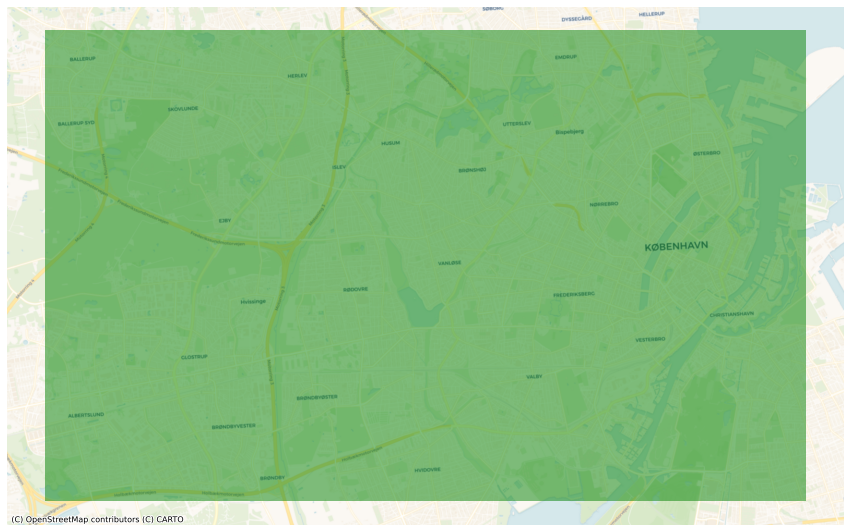

In [2]:
# Read polygon for study area
study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print('Please assign a crs to the study area polygon!')

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f'The size of the study area is {area / 1000000:.2f} square kilometers')

fig, ax = plt.subplots(1, figsize=(15,15))

study_area_poly.plot(
    ax=ax, 
    color = pdict["base"], 
    alpha = pdict["alpha_back"])

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

#### Create grid to be used in the analysis

The grid contains 770 square cells with a side length of 500m and an area of 0.25 square kilometers.


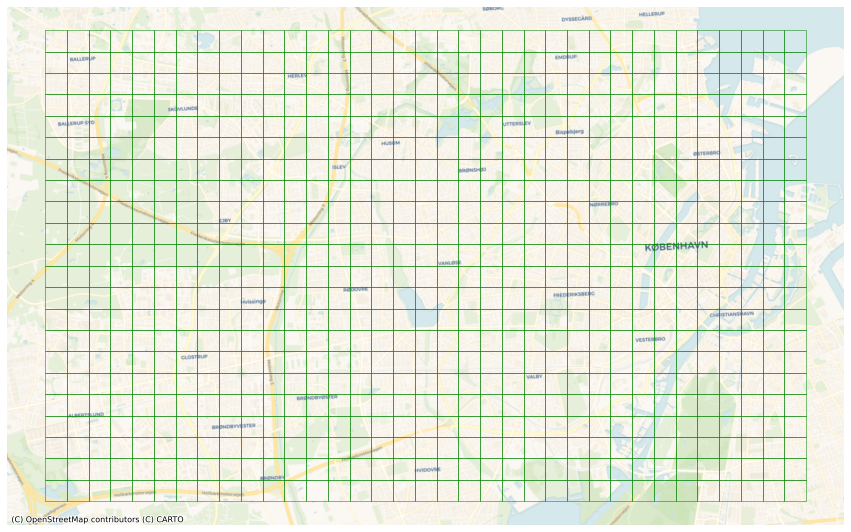

In [3]:
grid = ef.create_grid_geometry(study_area_poly, grid_cell_size)

grid['grid_id'] = grid.index

fig, ax = plt.subplots(1, figsize=(15,15))

grid_cell_area = (grid_cell_size/1000)**2 # in km2
print(f'The grid contains {len(grid)} square cells with a side length of {grid_cell_size}m and an area of {grid_cell_area:.2f} square kilometers.')

grid.plot(
    ax=ax, 
    facecolor = 'none', 
    edgecolor = pdict["base"], 
    alpha = pdict["alpha_back"])

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

### 2. Load OSM data

In this step we:
- Download data from OpenStreetMap using OSMnx
- Project the data to the chosen CRS
- Create a subnetwork consisting only of bicycle infrastructure
- Classify all edges in the bicycle network based on whether they are protected or unprotected bicycle infrastructure, how they have been digitised, and whether they allow for bidirectional travel or not
- Simplify the network *(to read more about the modified OSMnx simplification (Boeing, 2017) used here, we refer to this [Github repository](https://github.com/anerv/NERDS_osmnx) which contains both the simplification functions, explanation of the logic and a demonstration)*

Depending on the size of your study area, getting data through OSMnx can take a little while.

In [4]:
### Download OSM data
ox.settings.use_cache=False
ox.settings.useful_tags_way=osm_way_tags

graph_osm = ox.graph_from_polygon(
    study_area_poly.to_crs('EPSG:4326').loc[0, 'geometry'], 
    network_type='bike', 
    simplify=False, 
    retain_all=True, 
    truncate_by_edge=False, 
    clean_periphery=True
)

print('OSM data retrieved successfully!')    

OSM data retrieved successfully!


In [5]:
### CONVERT INTO GRAPH

# Project graph to chosen crs
graph_osm = ox.project_graph(graph_osm, to_crs=study_crs)

# Get osm_edges and osm_nodes
osm_nodes, osm_edges = ox.graph_to_gdfs(graph_osm)

# Clean up column names (removing ':' and upper case letters)
osm_edges = gf.clean_col_names(osm_edges)
osm_nodes = gf.clean_col_names(osm_nodes)

# Add attribute on whether bicycle infra exist or not (to be used by e.g. simplification function)
osm_edges['bicycle_infrastructure'] = 'no'

for q in bicycle_infrastructure_queries.values():

    try:
        ox_filtered = osm_edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)
        print('Please check if the columns used in the query are present in the data')

    osm_edges.loc[ox_filtered.index, 'bicycle_infrastructure'] = 'yes'

osm_edges.bicycle_infrastructure.value_counts()

bicycle_edges = osm_edges.loc[osm_edges.bicycle_infrastructure == 'yes'].copy()

bicycle_graph = graph_osm.edge_subgraph(bicycle_edges.index)
print('Successfully created network only with bicycle infrastructure!')

assert len(bicycle_edges) == len(bicycle_graph.edges)

bicycle_nodes, bicycle_edges = ox.graph_to_gdfs(bicycle_graph)
bicycle_edges = gf.clean_col_names(bicycle_edges)
bicycle_nodes = gf.clean_col_names(bicycle_nodes)

bicycle_edges['bicycle_infrastructure'] = 'yes'
bicycle_infrastructure_dict = bicycle_edges['bicycle_infrastructure'].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_infrastructure_dict, 'bicycle_infrastructure')

# Add "multiple edge" attribute to each edge of the graph
for e in bicycle_graph.edges:
    bicycle_graph.edges[e]['multiedge'] = 0

# Count multiple edges and store info at key 0 
# (simplification routine keeps only key 0)
for u, v, k in bicycle_graph.edges:
    if k > 0:
        bicycle_graph.edges[u, v, 0]['multiedge'] += 1

# Define whether bicycle infrastructure is in both or one direction and whether it is one- or bidirectional
bicycle_edges = ef.simplify_bicycle_tags(bicycle_edges)

bicycle_bidirectional_dict = bicycle_edges['bicycle_bidirectional'].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_bidirectional_dict, 'bicycle_bidirectional')

bicycle_geometries_dict = bicycle_edges['bicycle_geometries'].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_geometries_dict, 'bicycle_geometries')

# Classify edges as protected or unprotected
bicycle_edges = ef.define_protected_unprotected(bicycle_edges, osm_bicycle_infrastructure_type)

# Set edges attributes for column protected
bicycle_protected_dict = bicycle_edges['protected'].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_protected_dict, 'protected')

# Simplify bicycle network
bicycle_graph_simplified = sf.simplify_graph(
    bicycle_graph, 
    attributes=[
        'bicycle_infrastructure',
        'bicycle_bidirectional',
        'bicycle_geometries',
        'protected'
    ],
    remove_rings=False
)

# Get undirected network representation
bicycle_graph_simplified = ox.get_undirected(bicycle_graph_simplified)
bicycle_graph = ox.get_undirected(bicycle_graph)

bicycle_nodes_simplified, bicycle_edges_simplified = ox.graph_to_gdfs(bicycle_graph_simplified, nodes=True)

# Measure the length of bicycle infrastructure (!=from length of edges)
bicycle_edges_simplified['length'] = bicycle_edges_simplified.geometry.length
bicycle_edges_simplified['infrastructure_length'] = bicycle_edges_simplified.apply(
    lambda x: ef.measure_infrastructure_length(
        edge = x.geometry, 
        geometry_type=x.bicycle_geometries, 
        bidirectional=x.bicycle_bidirectional, 
        bicycle_infrastructure=x.bicycle_infrastructure), 
    axis=1
)

# Creating columns with unique feature id (required by some functions)
bicycle_edges['edge_id'] = bicycle_edges.reset_index().index
bicycle_edges_simplified['edge_id'] = bicycle_edges_simplified.reset_index().index

osm_id_dict = bicycle_edges['edge_id'].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_id_dict, 'edge_id')

osm_id_dict_s = bicycle_edges_simplified['edge_id'].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_id_dict_s, 'edge_id')

# Saving data to graphs
osm_l_dict = osm_edges['length'].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_l_dict, 'length')

osm_l_dict_s = bicycle_edges_simplified['length'].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_l_dict_s, 'length')

osm_il_dict = bicycle_edges_simplified['infrastructure_length'].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_il_dict, 'infrastructure_length')

# Overview of data from OSM
graph_area = ef.get_graph_area(bicycle_nodes, study_area_poly, study_crs)
print(f'The graph covers an area of {graph_area/ 1000000:.2f} square kilometers')
print(f'The length of the OSM network with bicycle infrastructure is {bicycle_edges_simplified.infrastructure_length.sum()/1000 :.2f} kilometers')

Successfully created network only with bicycle infrastructure!
Bidirectional Value Counts: 
 False    33128
True     17413
Name: bicycle_bidirectional, dtype: int64
Geometry Type Value Counts: 
 centerline         25775
true_geometries    24766
Name: bicycle_geometries, dtype: int64
Protected Value Counts: 
 protected      46207
unprotected     3719
mixed            615
Name: protected, dtype: int64
The graph covers an area of 179.70 square kilometers
The length of the OSM network with bicycle infrastructure is 1058.07 kilometers


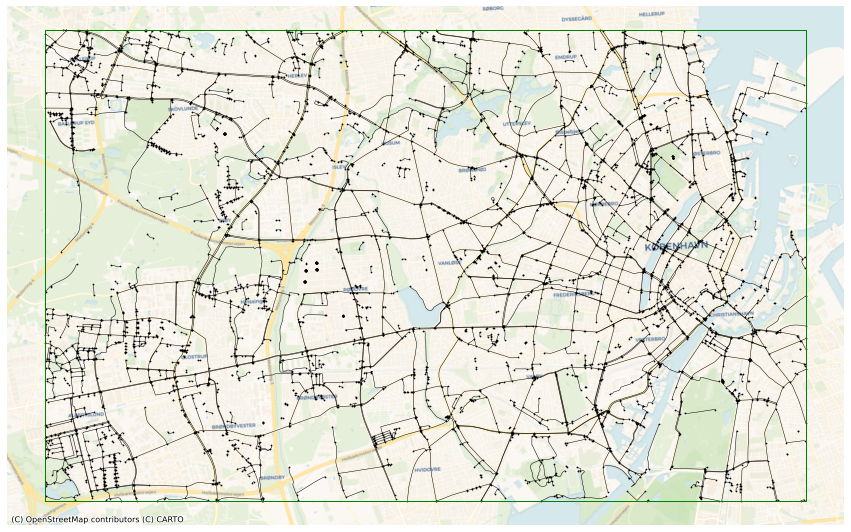

In [6]:
# Plot network

fig, ax = plt.subplots(1, figsize=(15,15))

bicycle_edges_simplified.plot(
    ax = ax, 
    color = pdict["osm_base"], 
    linewidth = 0.5)

bicycle_nodes_simplified.plot(
    ax = ax, 
    color = pdict["osm_base"], 
    markersize = 0.5)

study_area_poly.plot(
    ax=ax, 
    edgecolor = pdict["base"], 
    facecolor = 'None', 
    linewidth = 1)

cx.add_basemap(
    ax=ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager
)

ax.set_axis_off()

In [7]:
# Joining grid cell id to network elements
osm_edges_simp_joined = gpd.overlay(bicycle_edges_simplified.reset_index(), grid, how ='intersection')
osm_edges_joined = gpd.overlay(bicycle_edges.reset_index(), grid, how='intersection')

osm_nodes_simp_joined = gpd.overlay(bicycle_nodes_simplified.reset_index(), grid, how ='intersection')
osm_nodes_joined = gpd.overlay(bicycle_nodes.reset_index(), grid, how='intersection')

# Count features in each grid cell
all_data_osm = [osm_edges_joined,  osm_nodes_joined, osm_edges_simp_joined, osm_nodes_simp_joined]
labels_osm = ['osm_edges','osm_nodes','osm_simplified_edges','osm_simplified_nodes']

for data, label in zip(all_data_osm, labels_osm):

    df = ef.count_features_in_grid(data,label)

    grid = ef.merge_results(grid,df,'left')

# Recomputing infrastructure length for data joined to grid
osm_edges_simp_joined['length'] = osm_edges_simp_joined['geometry'].length
osm_edges_simp_joined['infrastructure_length'] = osm_edges_simp_joined.apply(
    lambda x: ef.measure_infrastructure_length(
        edge = x.geometry, 
        geometry_type=x.bicycle_geometries, 
        bidirectional=x.bicycle_bidirectional, 
        bicycle_infrastructure=x.bicycle_infrastructure), 
    axis=1
)

assert round(bicycle_edges_simplified.infrastructure_length.sum()/10000,0) == round(osm_edges_simp_joined.infrastructure_length.sum() / 10000,0) 

In [9]:
# Save data
bicycle_nodes['osmid'] = bicycle_nodes.index 
bicycle_nodes_simplified['osmid'] = bicycle_nodes_simplified.index
assert len(bicycle_nodes) == len(bicycle_nodes.osmid.unique())
assert len(bicycle_edges) == len(bicycle_edges.edge_id.unique())
assert len(bicycle_edges_simplified) == len(bicycle_edges_simplified.edge_id.unique())
assert len(bicycle_nodes_simplified) == len(bicycle_nodes_simplified.osmid.unique())

assert 'infrastructure_length' in bicycle_edges_simplified.columns
assert 'length' in bicycle_edges.columns

with open(osm_nodes_fp, 'wb') as f:
    pickle.dump(bicycle_nodes, f)

with open(osm_edges_fp, 'wb') as f:
    pickle.dump(bicycle_edges, f)

with open(osm_nodes_simplified_fp, 'wb') as f:
    pickle.dump(bicycle_nodes_simplified, f)

with open(osm_edges_simplified_fp, 'wb') as f:
    pickle.dump(bicycle_edges_simplified, f)

# Joined data
with open(osm_nodes_joined_fp, 'wb') as f:
    pickle.dump(osm_nodes_joined, f)

with open(osm_edges_joined_fp, 'wb') as f:
    pickle.dump(osm_edges_joined, f)

with open(osm_nodes_simplified_joined_fp, 'wb') as f:
    pickle.dump(osm_nodes_simp_joined, f)

with open(osm_edges_simplified_joined_fp, 'wb') as f:
    pickle.dump(osm_edges_simp_joined, f)

print('OSM nodes and edges saved successfully!')

ox.save_graphml(bicycle_graph, osm_graph_fp)
ox.save_graphml(bicycle_graph_simplified, osm_graph_simplified_fp)
print('OSM networks saved successfully!')

data_load_dict = {}

# Save time for when OSM data was loaded
current_time = datetime.now().strftime('%m/%d/%Y, %H:%M:%S')
data_load_dict['data_retrieved_at'] = current_time

with open(osm_meta_fp, 'w') as outfile:
    json.dump(data_load_dict, outfile)

OSM nodes and edges saved successfully!
OSM networks saved successfully!


In [10]:
# Export grid
grid.to_file(osm_grid_fp)
print('Grid saved successfully!')

/opt/miniconda3/envs/cdq/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Grid saved successfully!
